## Backtesting Sesion 1 (con Ejercicio Resuelto)
### Evaluación de Señales en Ventanas Deslizantes

Este cuaderno muestra un ejemplo de como realizar una evaluación fuera de los datos de optimización, utilizando ventanas deslizantes.  Las ideas generales las podemos resumir en:
- Escoger un conjunto de parámetros a partir de la exploración sobre un periodo de tiempo puede llevar a un sobre-ajuste de la estrategia
- Una evaluación más realista consiste calcular el rendimiento en un periodo diferente al de optimización
- Podemos simular un periodo continuo de evaluación concatenando ventanas deslizantes de entrenamiento/prueba 


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import itertools

____
### Datos 
Snapshot de acciones del IBEX35

In [2]:
import pickle
with open('../../data/stock_data.pkl', 'rb') as handle:
    stock_data = pickle.load(handle)

Generamos un único dataframe con los precios de cierre

In [3]:
close_dict = {tk: df.close for tk,df in stock_data.items()}
stock_close = pd.DataFrame(close_dict)
stock_close.head()

,SAN,BTO_1,BKIA_0,BKIA,NTGY,TRE,ACX_0,ACX,FER,ACS,...,DRC,PRS_0,PRS_1,SCYR_0,TEM,CAR,AGS,COL_0,A3TV,SGC
2003-01-02,2.251615,NaN,NaN,NaN,7.363463,NaN,4.761374,NaN,NaN,4.815096,...,16.50,49.590521,NaN,4.732566,5.88,NaN,NaN,NaN,NaN,9.35
2003-01-03,2.166648,NaN,NaN,NaN,7.270788,NaN,4.865828,NaN,NaN,4.815096,...,16.84,48.960800,NaN,4.740697,5.87,NaN,NaN,NaN,NaN,9.36
2003-01-07,2.251615,NaN,NaN,NaN,7.388738,NaN,4.778783,NaN,NaN,4.815096,...,16.29,48.488510,NaN,4.667513,6.03,NaN,NaN,NaN,NaN,9.19
2003-01-08,2.251615,NaN,NaN,NaN,7.582514,NaN,4.717851,NaN,NaN,4.905021,...,16.31,48.016219,NaN,4.651250,6.02,NaN,NaN,NaN,NaN,8.83
2003-01-09,2.251615,NaN,NaN,NaN,7.641489,NaN,4.752669,NaN,NaN,4.913196,...,16.51,47.543928,NaN,4.708171,6.13,NaN,NaN,NaN,NaN,9.26


Trabajaremos primero con un solo valor, que podemos ir variando

In [4]:
ticker = 'TEF'
stock_series = stock_close[ticker].dropna()

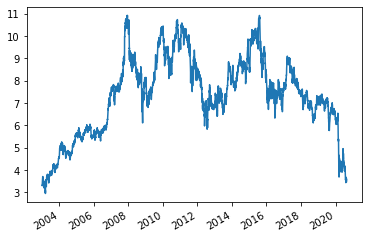

In [5]:
stock_series.plot()

___

In [8]:
import sys
sys.path.append('../')

In [9]:
from stoosc import Sto # clase con las funciones del oscilador estocastico

In [10]:
Sto.backtest_so_returns(stock_series, win=25, obought=0.8, osold=0.2)

0.0023311595972059784

Conjunto de parámetros para la exploración. (Igual que en cuaderno 1.1)

In [11]:
obought_params = [0.70, 0.80, 0.90]
osold_params = [0.10, 0.20, 0.30]
win_params = [20, 30, 50]
combined_params = list(itertools.product(win_params, obought_params, osold_params))
combined_params[:10]

[(20, 0.7, 0.1),
 (20, 0.7, 0.2),
 (20, 0.7, 0.3),
 (20, 0.8, 0.1),
 (20, 0.8, 0.2),
 (20, 0.8, 0.3),
 (20, 0.9, 0.1),
 (20, 0.9, 0.2),
 (20, 0.9, 0.3),
 (30, 0.7, 0.1)]

____
### Función de Exploración 
Reutilizamos código de exploración para tener una función que dado un espacio de parámetros y una serie, nos devuelva
la mejor rentabilidad obtenida, y la combinación que lo produce

In [12]:
?Sto.backtest_so_returns

Signature: Sto.backtest_so_returns(vseries, win=20, obought=0.8, osold=0.2)
Docstring:
Devuelve la rentabilidad anualizada que se consigue al aplicar
la regla de trading del oscilador estocastico a la serie de precios
vseries 
File:      c:\users\trosa\onedrive - bme\documentos\docencia_bme\backtesting\notebooks\sesion1\stoosc.py
Type:      function


In [13]:
def explore_sto_params(params_product, vseries):
    result = {}
    for iparams in params_product:
        (w, b, s) = iparams
        result[iparams] = Sto.backtest_so_returns(vseries, win=w, obought=b, osold=s)
    rseries = pd.Series(result)
    return rseries.idxmax(), rseries.max()

In [14]:
subserie = stock_series.loc[:'2005']
subserie

2003-01-02    3.308638
2003-01-03    3.292136
2003-01-07    3.490160
2003-01-08    3.498411
2003-01-09    3.556167
                ...   
2005-12-23    5.528149
2005-12-27    5.552902
2005-12-28    5.552902
2005-12-29    5.577655
2005-12-30    5.552902
Name: TEF, Length: 757, dtype: float64

In [15]:
explore_sto_params(combined_params, subserie)

((20, 0.9, 0.3), 0.1310992273211804)

### Ventanas

In [16]:
years = list(np.arange(2003,2021))
years

[2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020]

___
### Diseño Experimental -- Solución al Ejercicio Propuesto
- Utilizar 2 años para determinar la mejor combinación de parámetros
- Utilizamos la mejor combinación en los 3 años posteriores para evaluar el rendimiento.

Este enfoque más realista porque si tuvieramos que decidir **hoy** que parámetros elegir, 
podemos elegir la combinación del pasado, pero nuestro resultado real es el que conseguiríamos
a partir de aquí en adelante

In [24]:
# Separacion en años
for yd in range(4):
    for i in range(len(years) - 3 - yd):
        print(years[i:i+1+yd], years[i+1+yd:i+4+yd])

[2003] [2004, 2005, 2006]
[2004] [2005, 2006, 2007]
[2005] [2006, 2007, 2008]
[2006] [2007, 2008, 2009]
[2007] [2008, 2009, 2010]
[2008] [2009, 2010, 2011]
[2009] [2010, 2011, 2012]
[2010] [2011, 2012, 2013]
[2011] [2012, 2013, 2014]
[2012] [2013, 2014, 2015]
[2013] [2014, 2015, 2016]
[2014] [2015, 2016, 2017]
[2015] [2016, 2017, 2018]
[2016] [2017, 2018, 2019]
[2017] [2018, 2019, 2020]
[2003, 2004] [2005, 2006, 2007]
[2004, 2005] [2006, 2007, 2008]
[2005, 2006] [2007, 2008, 2009]
[2006, 2007] [2008, 2009, 2010]
[2007, 2008] [2009, 2010, 2011]
[2008, 2009] [2010, 2011, 2012]
[2009, 2010] [2011, 2012, 2013]
[2010, 2011] [2012, 2013, 2014]
[2011, 2012] [2013, 2014, 2015]
[2012, 2013] [2014, 2015, 2016]
[2013, 2014] [2015, 2016, 2017]
[2014, 2015] [2016, 2017, 2018]
[2015, 2016] [2017, 2018, 2019]
[2016, 2017] [2018, 2019, 2020]
[2003, 2004, 2005] [2006, 2007, 2008]
[2004, 2005, 2006] [2007, 2008, 2009]
[2005, 2006, 2007] [2008, 2009, 2010]
[2006, 2007, 2008] [2009, 2010, 2011]
[2007, 200

____
incluimos la evaluación fuera de los años de ajuste

In [25]:
result = {}
for yd in range(4):
    fit_rets = []
    test_rets = []
    for i in range(len(years) - 3 - yd):
        fityears = years[i:i+1+yd]
        fitseries = stock_series.loc[f'{fityears[0]}':f'{fityears[-1]}']

        best_params, best_ret = explore_sto_params(combined_params, fitseries)
        print(fityears, ':', best_params,np.round(best_ret,3))
        fit_rets.append(best_ret)

        # Ejecutamos la funcion del backtesting para calcular resultado con los parametros seleccionados
        testyears = years[i+1+yd:i+4+yd]
        testseries = stock_series.loc[f'{testyears[0]}':f'{testyears[-1]}']

        w, b, s = best_params
        test_ret = Sto.backtest_so_returns(testseries, win=w, obought=b, osold=s)
        print("--> Test:", testyears, best_params, np.round(test_ret,3))
        test_rets.append(test_ret)
    result[yd+1] = pd.DataFrame({
        'fit': fit_rets,
        'test': test_rets,
    })

[2003] : (20, 0.9, 0.1) 0.214
--> Test: [2004, 2005, 2006] (20, 0.9, 0.1) 0.117
[2004] : (30, 0.7, 0.1) 0.266
--> Test: [2005, 2006, 2007] (30, 0.7, 0.1) 0.076
[2005] : (30, 0.7, 0.1) 0.13
--> Test: [2006, 2007, 2008] (30, 0.7, 0.1) 0.024
[2006] : (20, 0.7, 0.3) 0.284
--> Test: [2007, 2008, 2009] (20, 0.7, 0.3) -0.068
[2007] : (50, 0.7, 0.3) 0.353
--> Test: [2008, 2009, 2010] (50, 0.7, 0.3) -0.013
[2008] : (20, 0.9, 0.2) 0.056
--> Test: [2009, 2010, 2011] (20, 0.9, 0.2) -0.03
[2009] : (30, 0.9, 0.3) 0.145
--> Test: [2010, 2011, 2012] (30, 0.9, 0.3) -0.04
[2010] : (30, 0.9, 0.3) 0.219
--> Test: [2011, 2012, 2013] (30, 0.9, 0.3) -0.124
[2011] : (50, 0.9, 0.1) -0.102
--> Test: [2012, 2013, 2014] (50, 0.9, 0.1) 0.099
[2012] : (50, 0.9, 0.3) 0.092
--> Test: [2013, 2014, 2015] (50, 0.9, 0.3) -0.02
[2013] : (20, 0.7, 0.3) 0.359
--> Test: [2014, 2015, 2016] (20, 0.7, 0.3) -0.023
[2014] : (30, 0.8, 0.2) 0.232
--> Test: [2015, 2016, 2017] (30, 0.8, 0.2) -0.066
[2015] : (30, 0.9, 0.2) 0.106
--> T

____

fit         NaN
test   -0.18793
dtype: float64
test: -0.009798378546246603
fit         NaN
test   -0.14674
dtype: float64
test: -0.009703396727101712
fit          NaN
test   -0.116523
dtype: float64
test: -0.017858252695880525
fit          NaN
test   -0.112034
dtype: float64
test: -0.021221749973448334


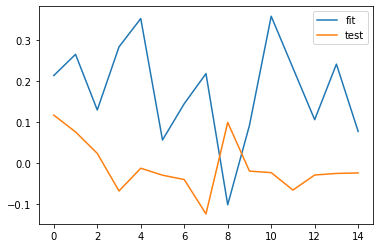

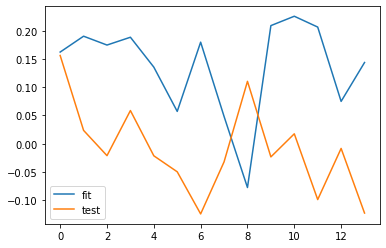

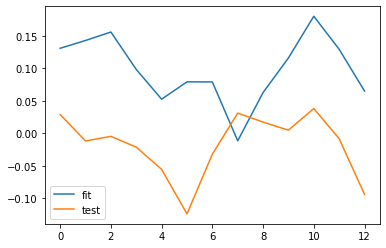

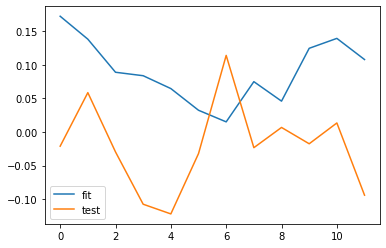

In [38]:
for i in range(1,5):
    result[i].plot()
    print(result[i].diff(axis=1).mean())
    print('test:', result[i].test.mean())